In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
from src.load_data import load_data
from src.parameters import EDGE_ORDER, EDGE_SPACING

epoch_key = 'Jaq', 3, 12 # animal, day, epoch

data = load_data(epoch_key)

02-Dec-20 10:23:06 Loading position info...
02-Dec-20 10:23:41 Loading multiunit...
02-Dec-20 10:24:07 Loading spikes...
02-Dec-20 10:25:37 Finding ripple times...


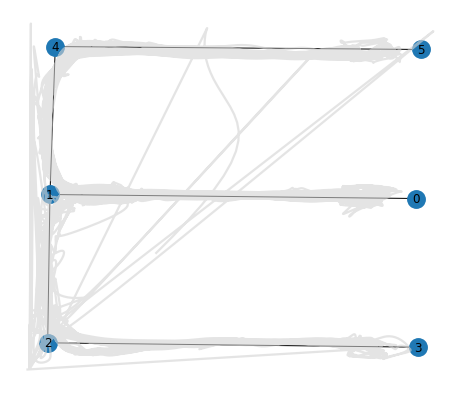

In [4]:
from track_linearization import plot_track_graph

plt.figure(figsize=(8, 7))
plt.plot(data['position_info'].tailBase_x, data['position_info'].tailBase_y, color='lightgrey', alpha=0.6)
plot_track_graph(data['track_graph'])
sns.despine(bottom=True, left=True)

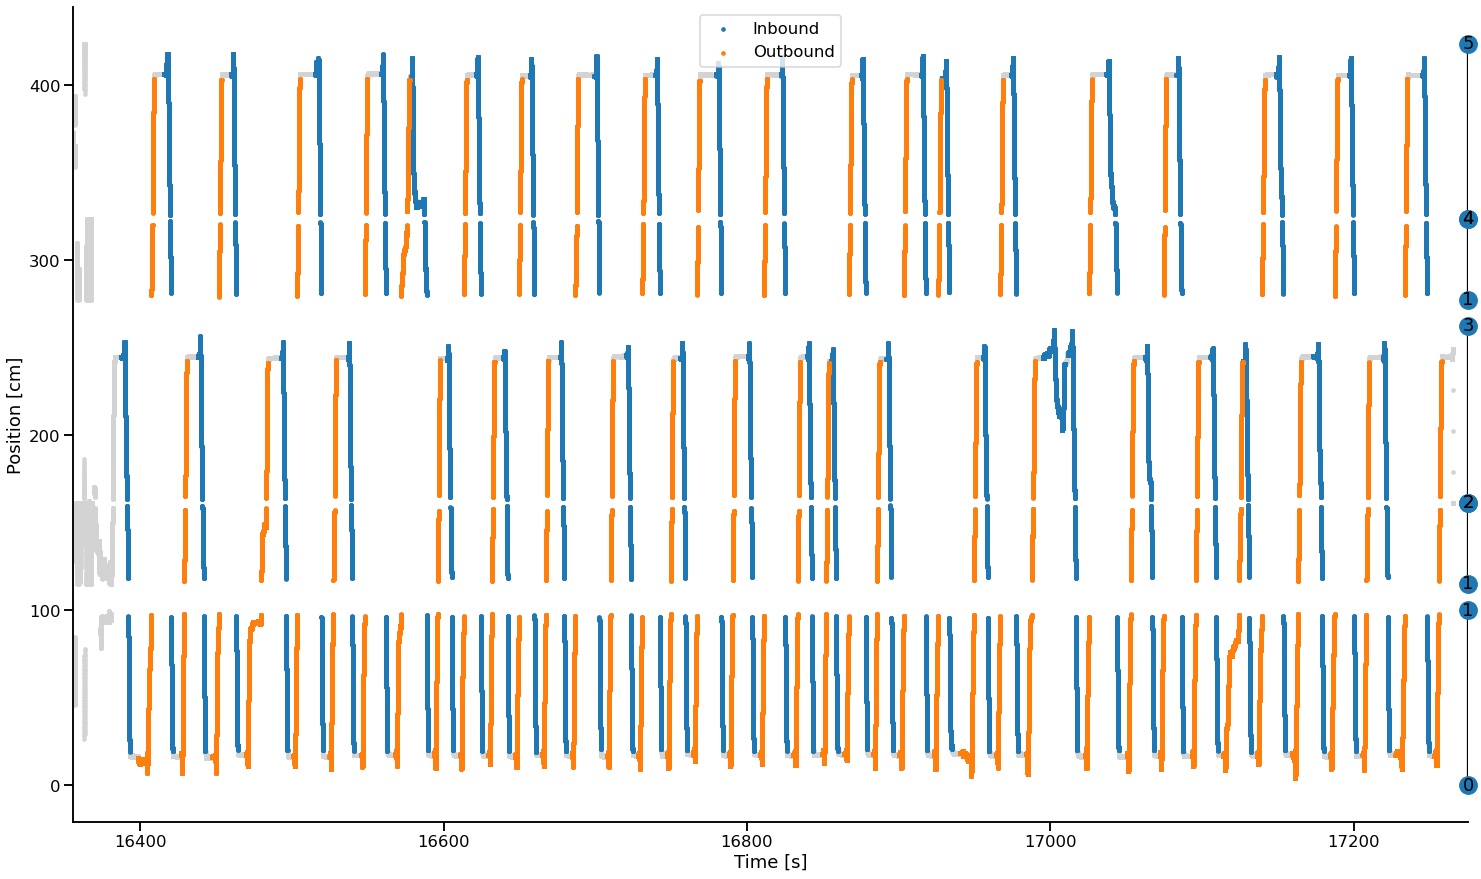

In [5]:
from track_linearization import plot_graph_as_1D

plt.figure(figsize=(25, 15))

time = data['position_info'].index / np.timedelta64(1, 's')
plt.scatter(time,
            data['position_info'].linear_position, color='lightgrey', s=10)

for name, df in data['position_info'].groupby('task'):
    plt.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=10, label=name)

plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=10.0 + time[-1])

plt.legend()
plt.ylabel('Position [cm]')
plt.xlabel('Time [s]')
plt.xlim((time[0], time[-1] + 10.0))

sns.despine()

In [6]:
continuous_transition_types = (
    [['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform'],
     ['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform']])

encoding_group_to_state = ['Inbound', 'Inbound', 'Outbound', 'Outbound']


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

In [7]:
from replay_trajectory_classification import ClusterlessClassifier

classifier = ClusterlessClassifier(**classifier_parameters)

In [8]:
data["position_info"].task.unique()

array([nan, 'Inbound', 'Outbound'], dtype=object)

In [33]:
data["position_info"].task.value_counts()

Outbound    111800
Inbound     107627
Name: task, dtype: int64

In [34]:
data["position_info"].shape

(454822, 36)

In [9]:
import pandas as pd

inbound_outbound_labels = np.asarray(data["position_info"].task).astype(str)

is_running = (np.abs(data["position_info"].tailBase_vel) > 4) & pd.notnull(data["position_info"].task)

classifier.fit(
    position=data["position_info"].linear_position,
    multiunits=data["multiunits"],
    is_training=is_running,
    track_graph=data["track_graph"],
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
    encoding_group_labels=inbound_outbound_labels,
    encoding_group_to_state=encoding_group_to_state
)

02-Dec-20 10:26:41 Fitting initial conditions...
02-Dec-20 10:26:42 Fitting state transition...
02-Dec-20 10:26:43 Fitting multiunits...


ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'random_walk', 'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform', 'uniform'],
                                                   ['random_walk', 'uniform',
                                                    'random_walk', 'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform', 'uniform']],
                      discrete_transition_diag=0.968,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([20., 20., 

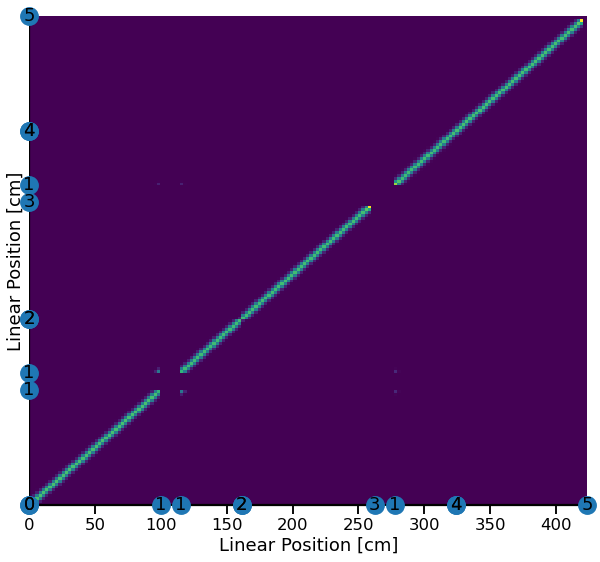

In [10]:
plt.figure(figsize=(10, 9))
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[0, 0].T)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)

In [11]:
data['ripple_times']

,start_time,end_time,duration
replay_number,,,
1,0 days 04:33:04.373699999,0 days 04:33:04.455033333,0.081333
2,0 days 04:33:05.002366666,0 days 04:33:05.095699999,0.093333
3,0 days 04:33:06.387033333,0 days 04:33:06.594366666,0.207333
4,0 days 04:33:14.317033333,0 days 04:33:14.370366666,0.053333
5,0 days 04:33:16.437033333,0 days 04:33:16.547699999,0.110667
...,...,...,...
205,0 days 04:47:31.024366666,0 days 04:47:31.125033333,0.100667
206,0 days 04:47:32.435699999,0 days 04:47:32.514366666,0.078667
207,0 days 04:47:33.106366666,0 days 04:47:33.172366666,0.066000


In [65]:
def plot_ripple_decode(data, classifier, ripple_number):
    start_time = data['ripple_times'].loc[ripple_number].start_time
    end_time = data['ripple_times'].loc[ripple_number].end_time

    results = classifier.predict(
        multiunits=data['multiunits'].sel(time=slice(start_time, end_time)),
        time=data['multiunits'].sel(time=slice(start_time, end_time)).time / np.timedelta64(1, 's'),
        state_names=['Inbound-Continuous', 'Inbound-Fragmented', 'Outbound-Continuous', 'Outbound-Fragmented']
        )

    fragmented = (results
                  .acausal_posterior
                  .sel(state=['Inbound-Fragmented', 'Outbound-Fragmented'])
                  .sum(['state', 'position'])
                  .assign_coords({'state': 'Fragmented'}))
    probability = (results
                   .acausal_posterior
                   .sum('position')
                   .drop_sel(state=['Inbound-Fragmented', 'Outbound-Fragmented']))
    probability = xr.concat((probability, fragmented), dim='state')

    fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(16, 8),
                             gridspec_kw=dict(height_ratios=[1, 3]))
    h = probability.plot(x='time', hue='state', ax=axes[0], add_legend=False, clip_on=False)
    axes[0].set_ylabel('Prob.')
    axes[0].set_ylim((0.0, 1.0))
    axes[0].set_yticks((0.0, 1.0))
    axes[0].set_xlabel('')
    axes[0].set_xlim((start_time / np.timedelta64(1, 's'), end_time / np.timedelta64(1, 's')))
    axes[0].legend(handles=h, labels=probability.state.values.tolist(),
                   bbox_to_anchor=(1.175, 0.8), loc='upper right', ncol=1, fontsize=10)
    results.acausal_posterior.sum('state', skipna=False).plot(x='time', y='position', ax=axes[1], robust=True, vmin=0.0)
    plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=end_time / np.timedelta64(1, 's'), ax=axes[1])
    sns.despine()

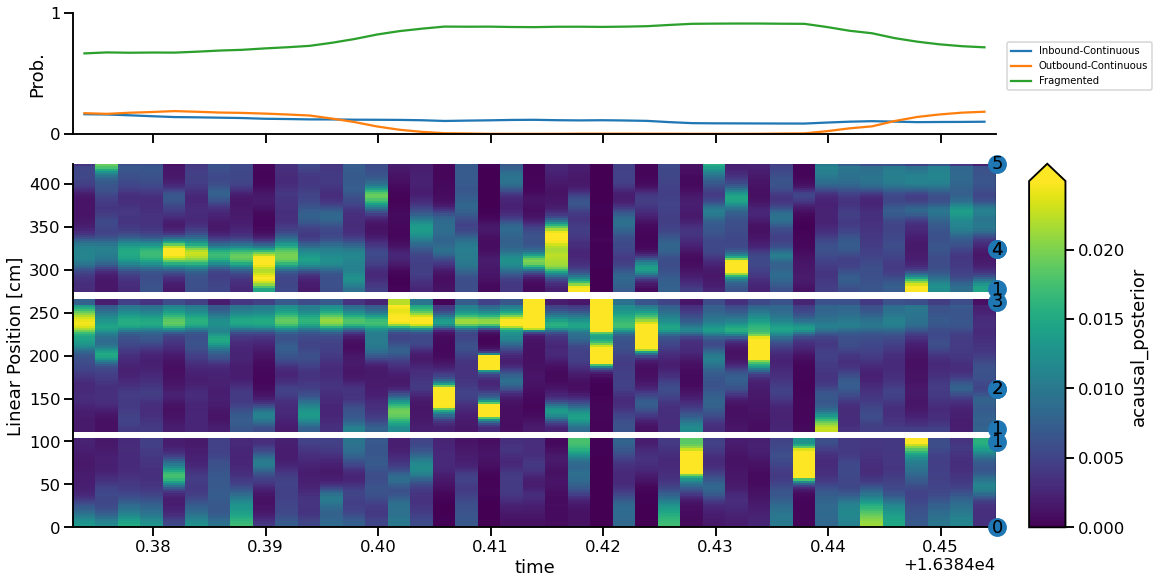

In [66]:
ripple_number = 1

plot_ripple_decode(data, classifier, ripple_number)

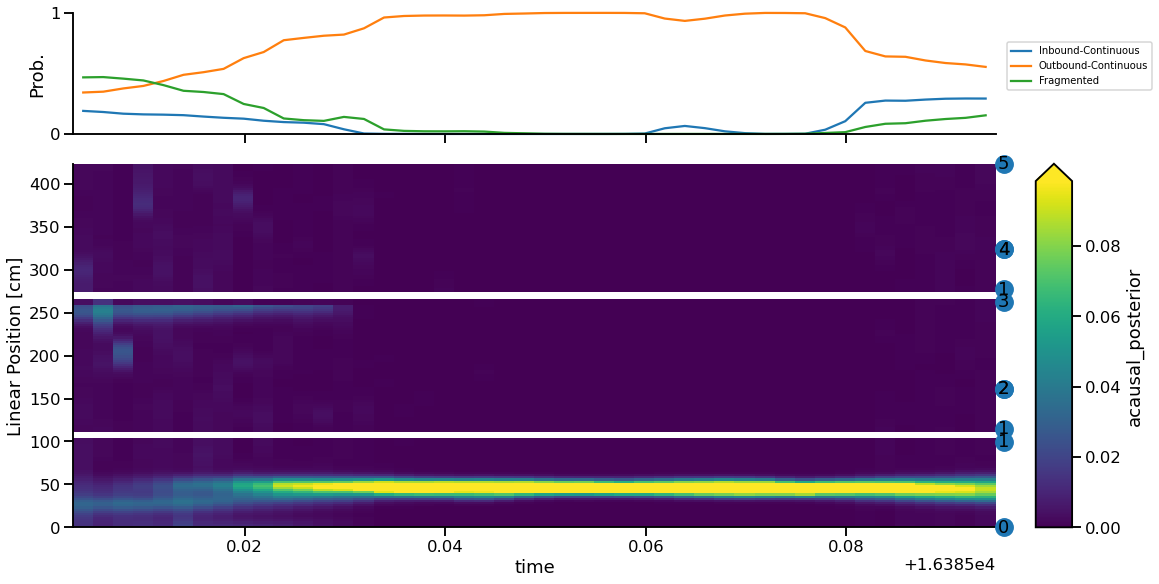

In [67]:
ripple_number = 2

plot_ripple_decode(data, classifier, ripple_number)

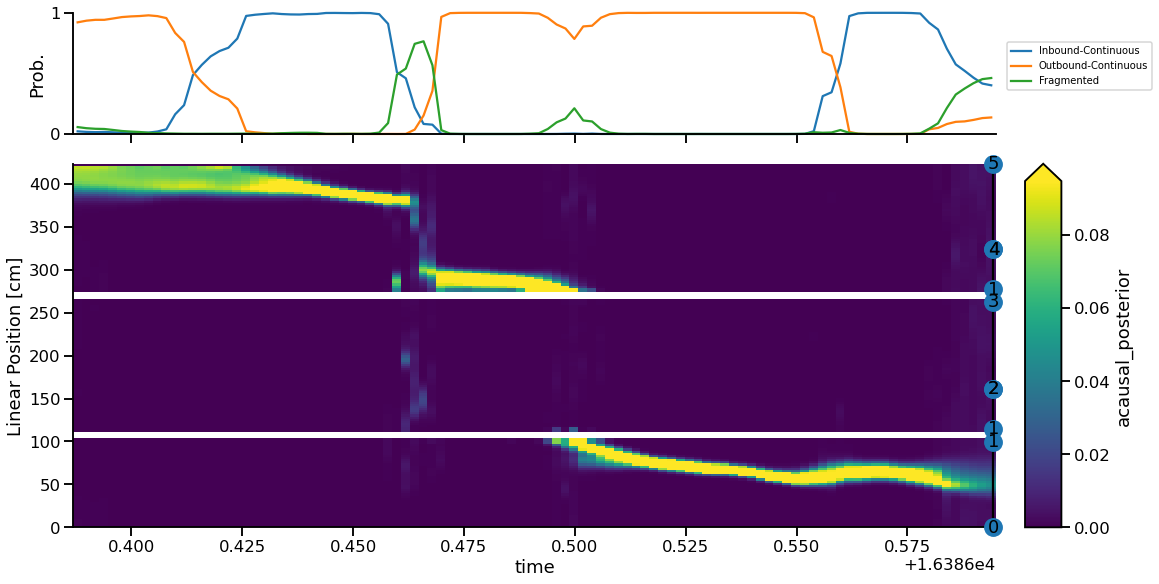

In [68]:
ripple_number = 3

plot_ripple_decode(data, classifier, ripple_number)

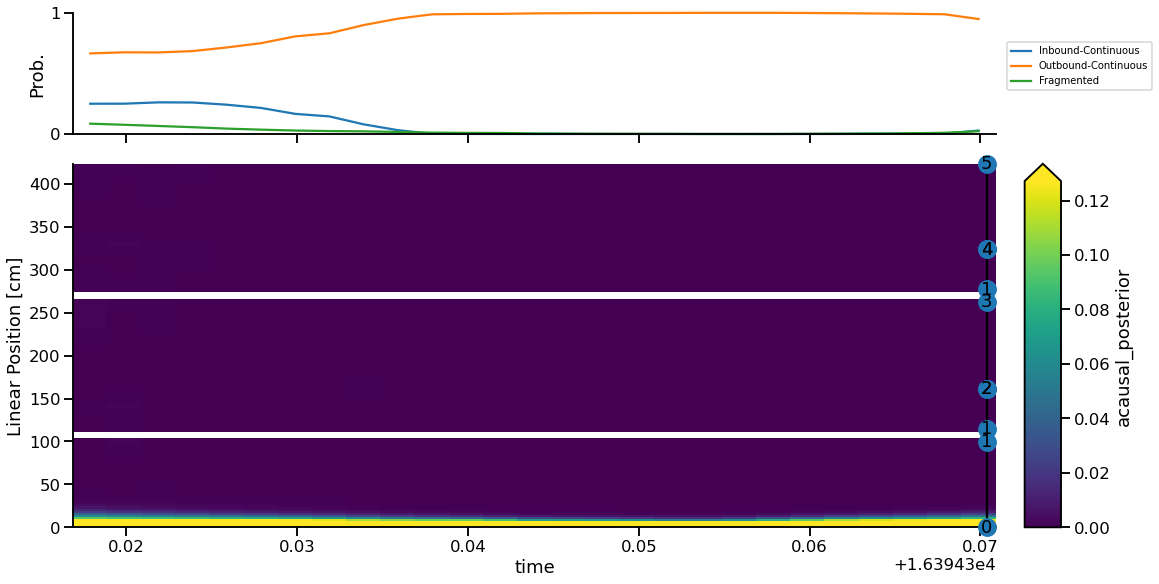

In [69]:
ripple_number = 4

plot_ripple_decode(data, classifier, ripple_number)

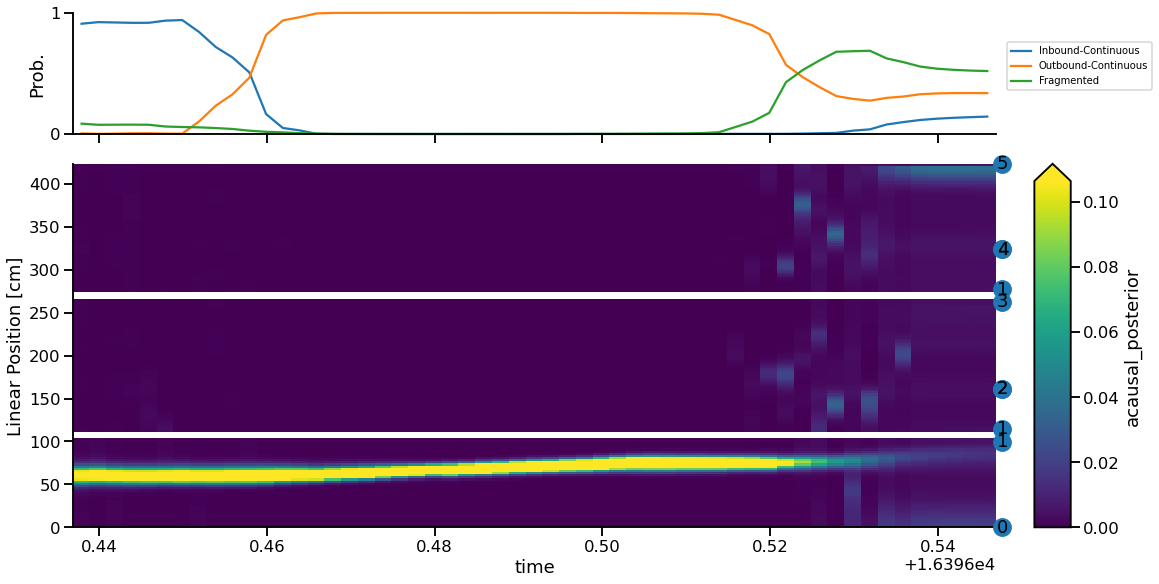

In [70]:
ripple_number = 5

plot_ripple_decode(data, classifier, ripple_number)

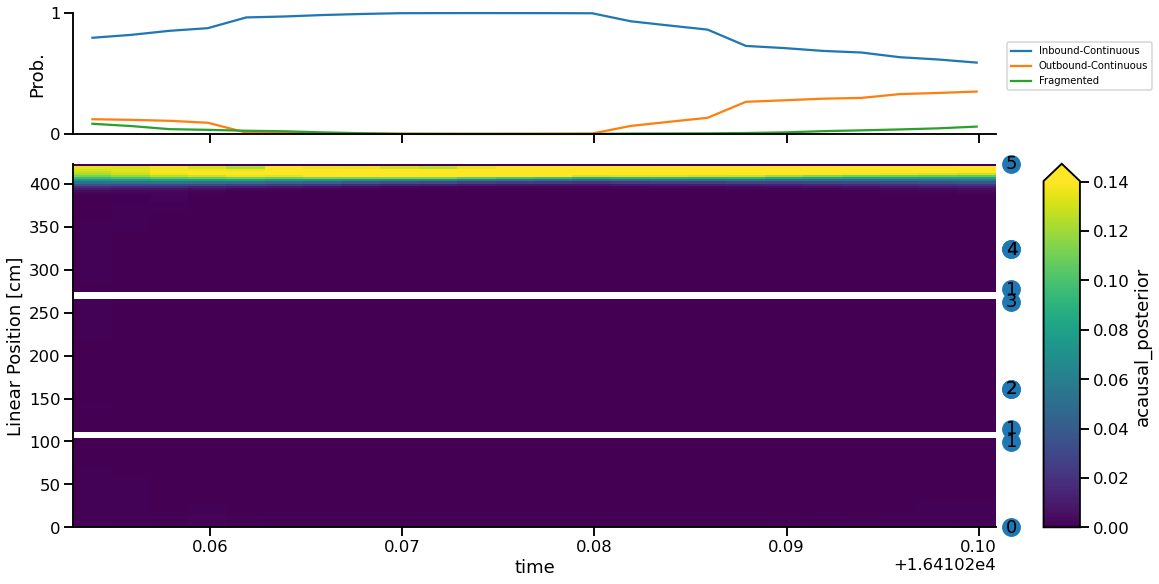

In [71]:
ripple_number = 6

plot_ripple_decode(data, classifier, ripple_number)

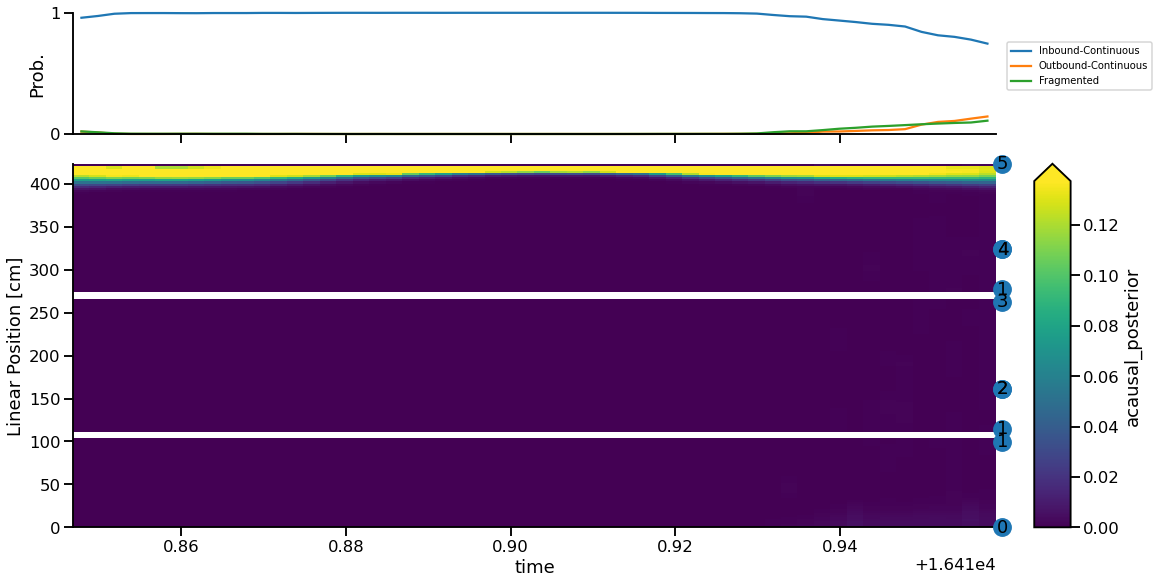

In [72]:
ripple_number = 7

plot_ripple_decode(data, classifier, ripple_number)

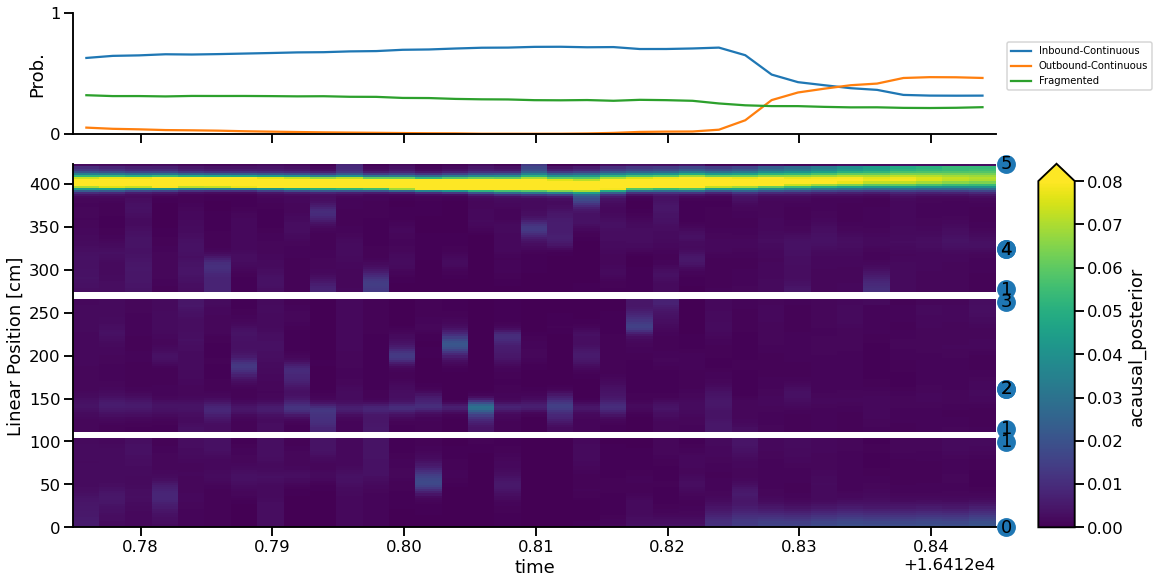

In [73]:
ripple_number = 8

plot_ripple_decode(data, classifier, ripple_number)

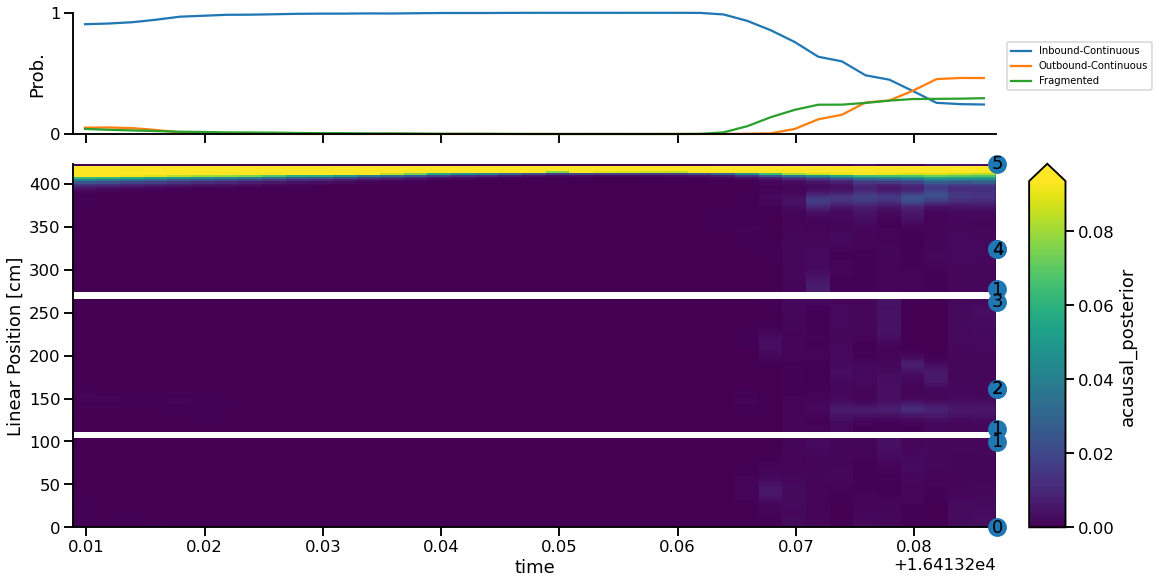

In [74]:
ripple_number = 9

plot_ripple_decode(data, classifier, ripple_number)

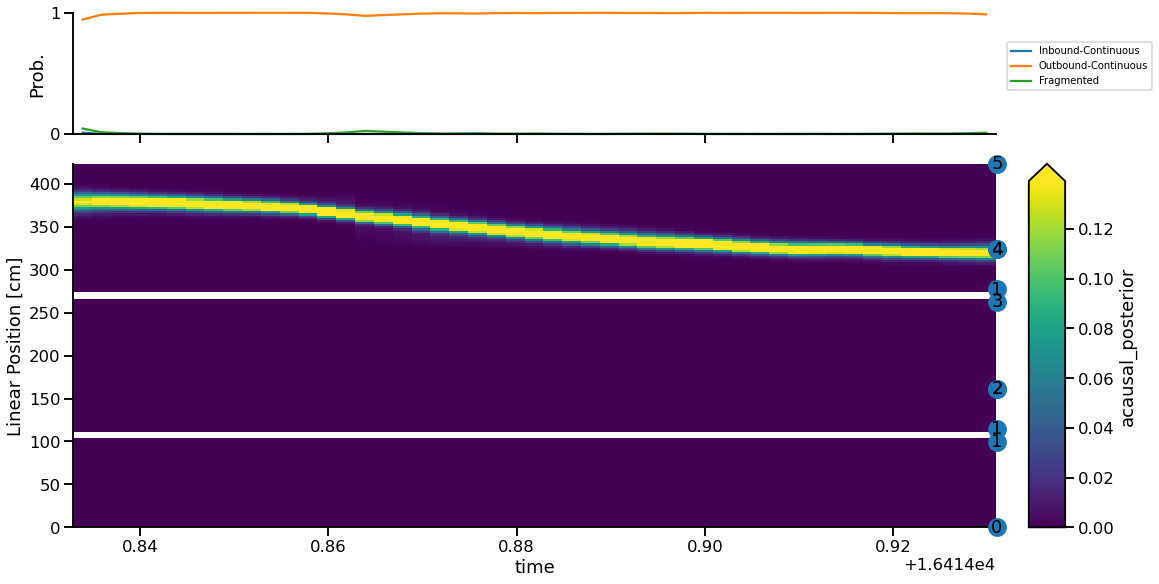

In [75]:
ripple_number = 10

plot_ripple_decode(data, classifier, ripple_number)

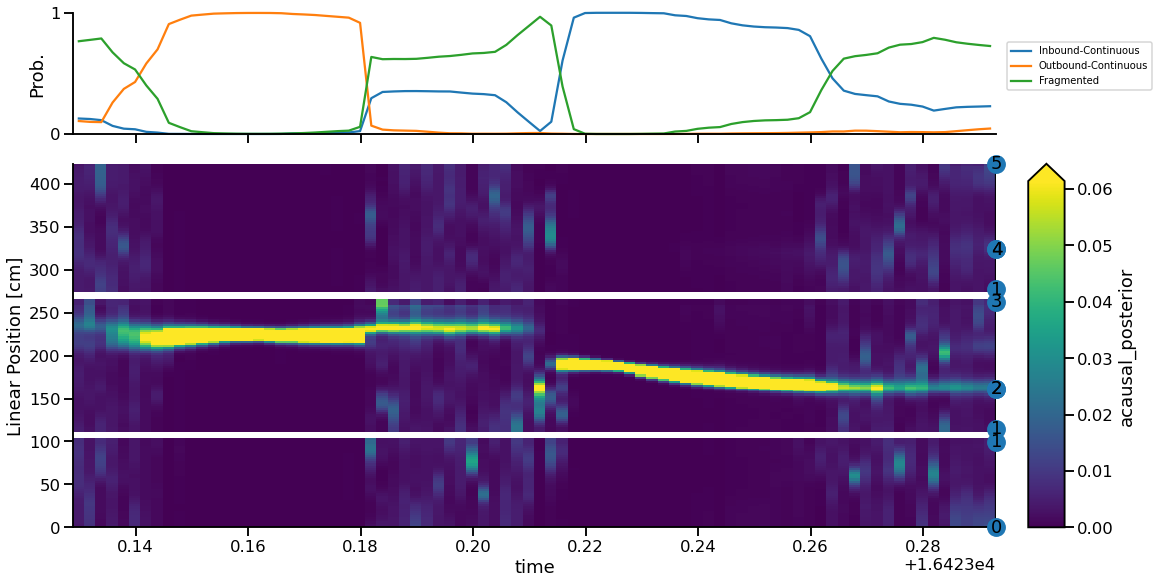

In [76]:
ripple_number = 11

plot_ripple_decode(data, classifier, ripple_number)

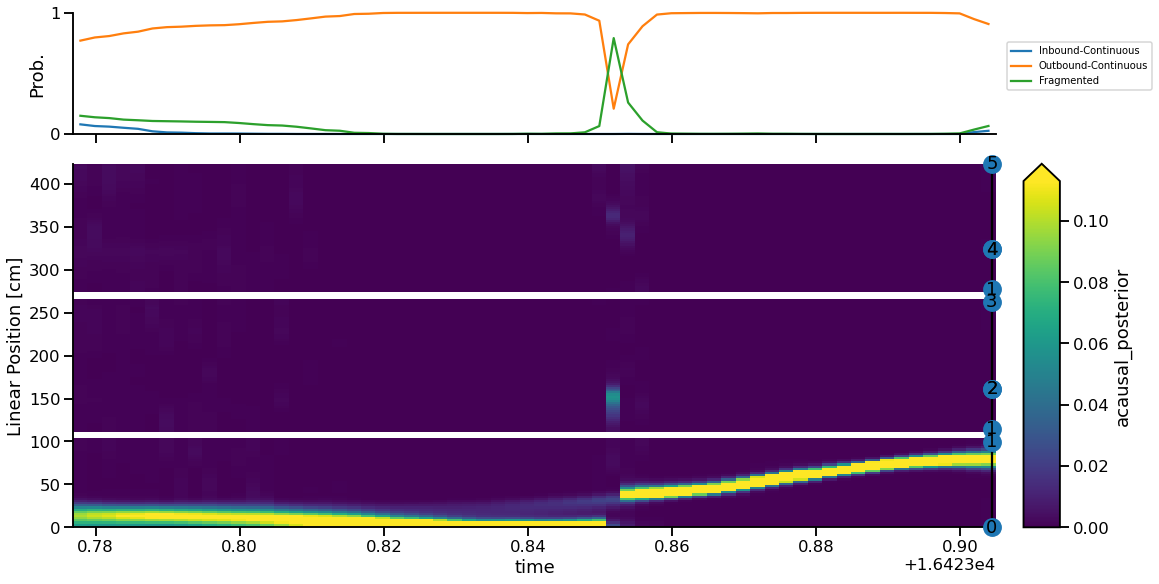

In [77]:
ripple_number = 12

plot_ripple_decode(data, classifier, ripple_number)

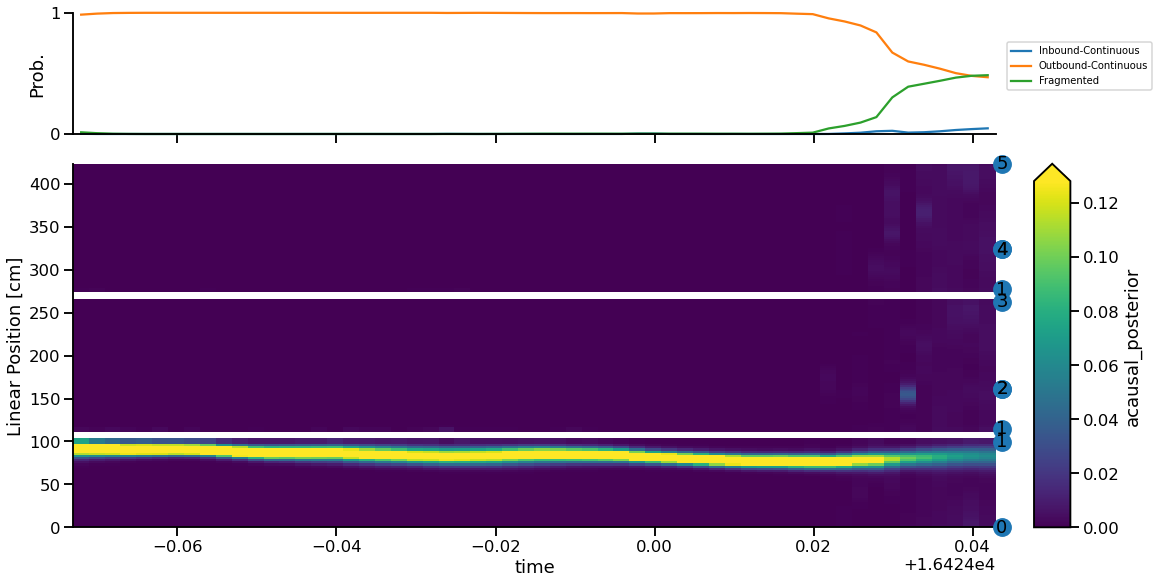

In [78]:
ripple_number = 13

plot_ripple_decode(data, classifier, ripple_number)

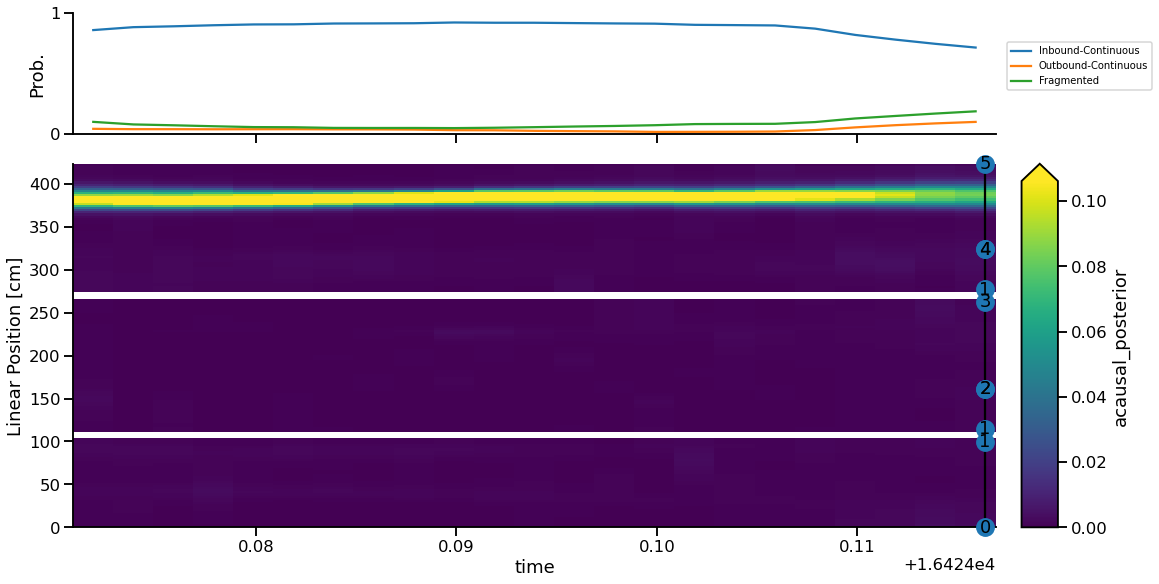

In [79]:
ripple_number = 14

plot_ripple_decode(data, classifier, ripple_number)

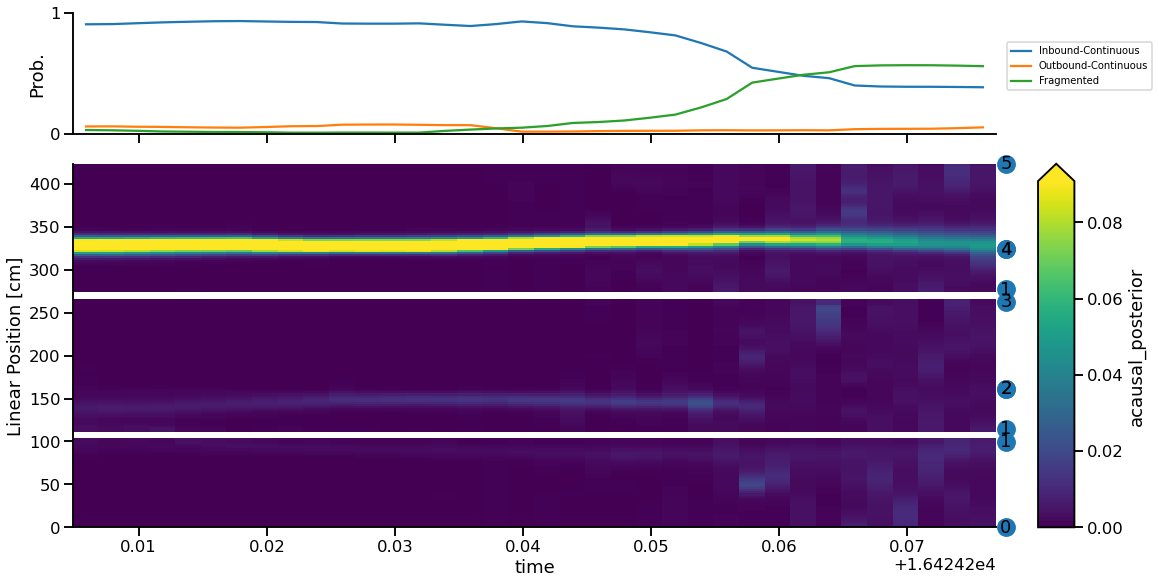

In [80]:
ripple_number = 15

plot_ripple_decode(data, classifier, ripple_number)

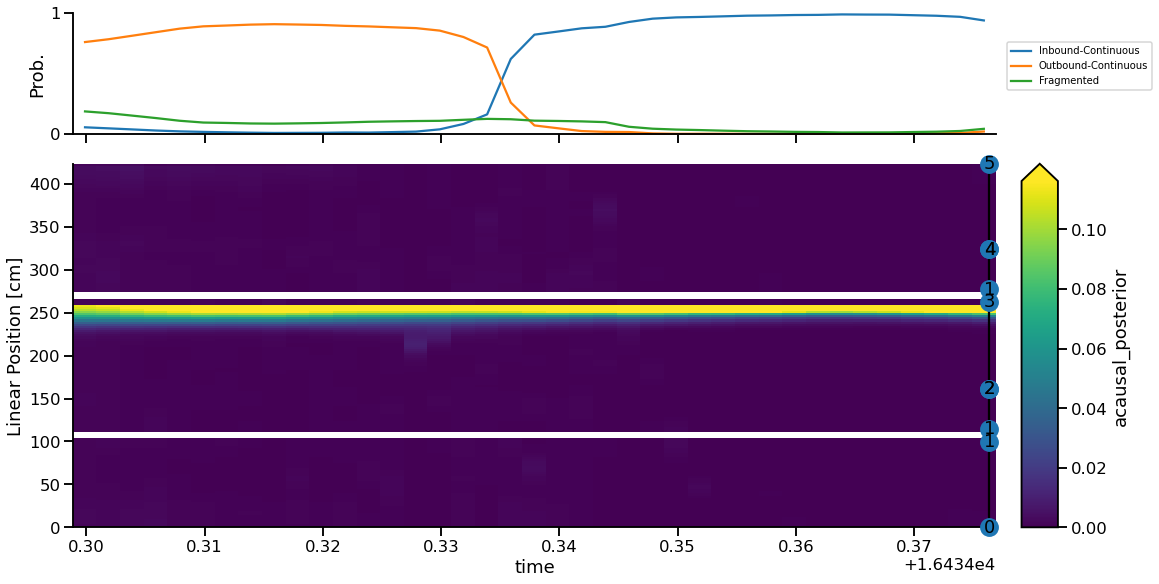

In [81]:
ripple_number = 16

plot_ripple_decode(data, classifier, ripple_number)

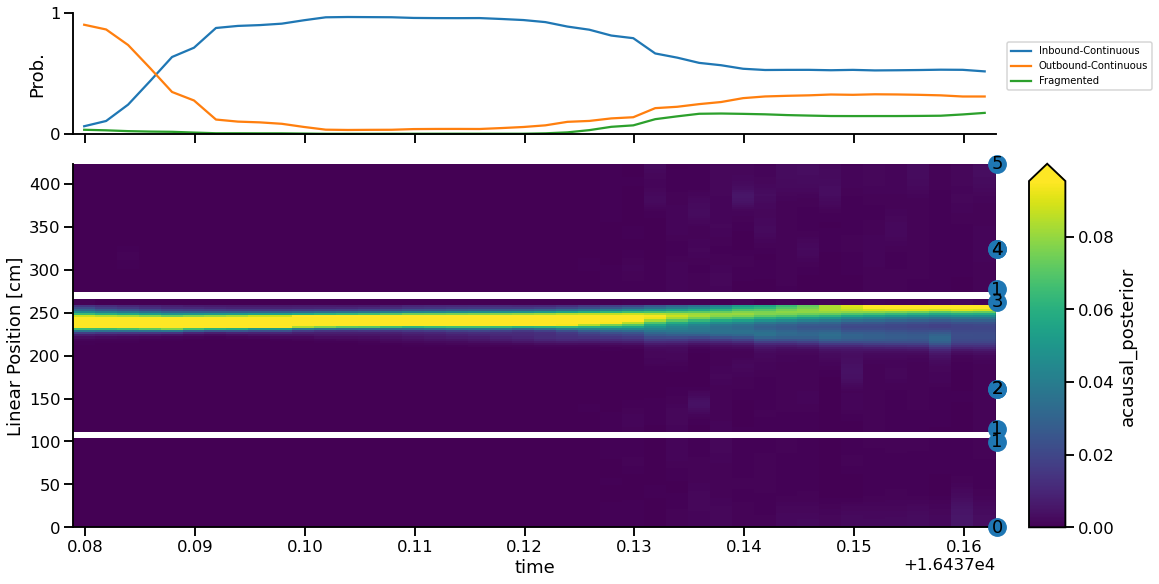

In [82]:
ripple_number = 17

plot_ripple_decode(data, classifier, ripple_number)

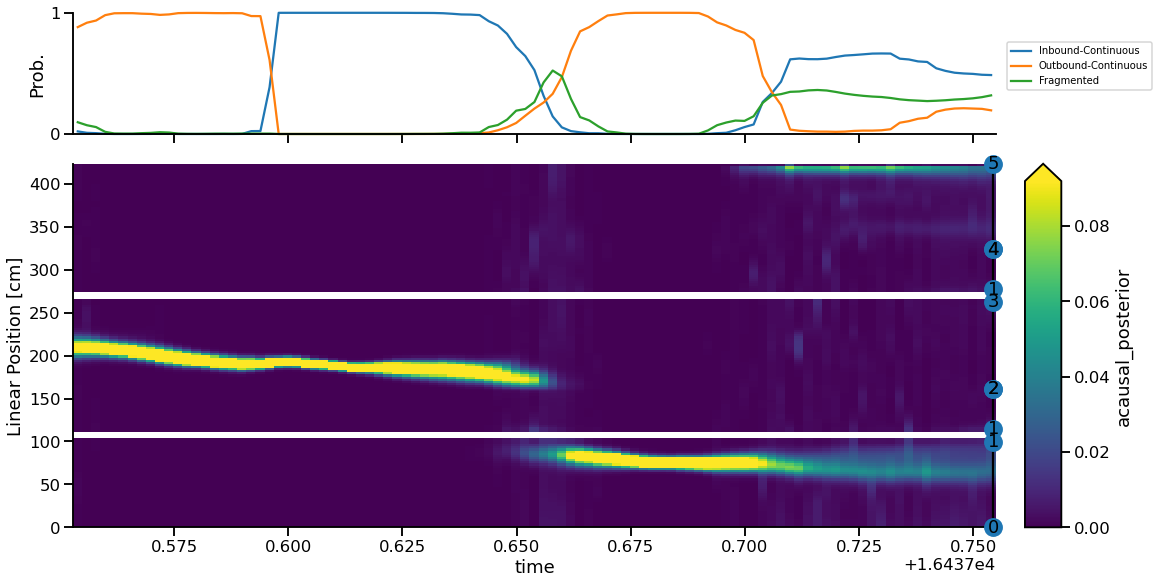

In [83]:
ripple_number = 18

plot_ripple_decode(data, classifier, ripple_number)

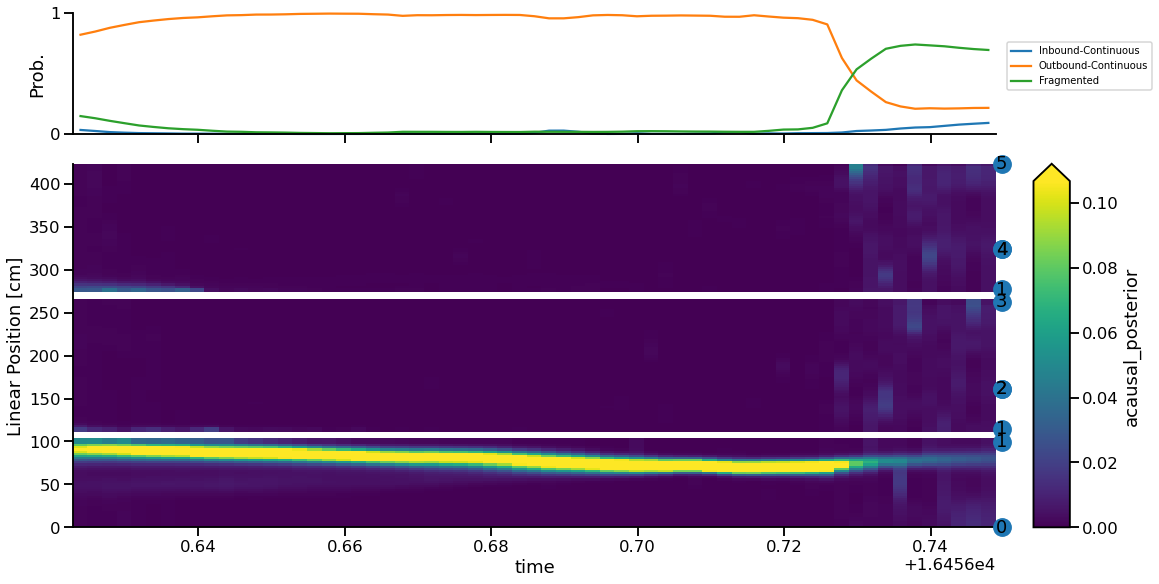

In [84]:
ripple_number = 19

plot_ripple_decode(data, classifier, ripple_number)

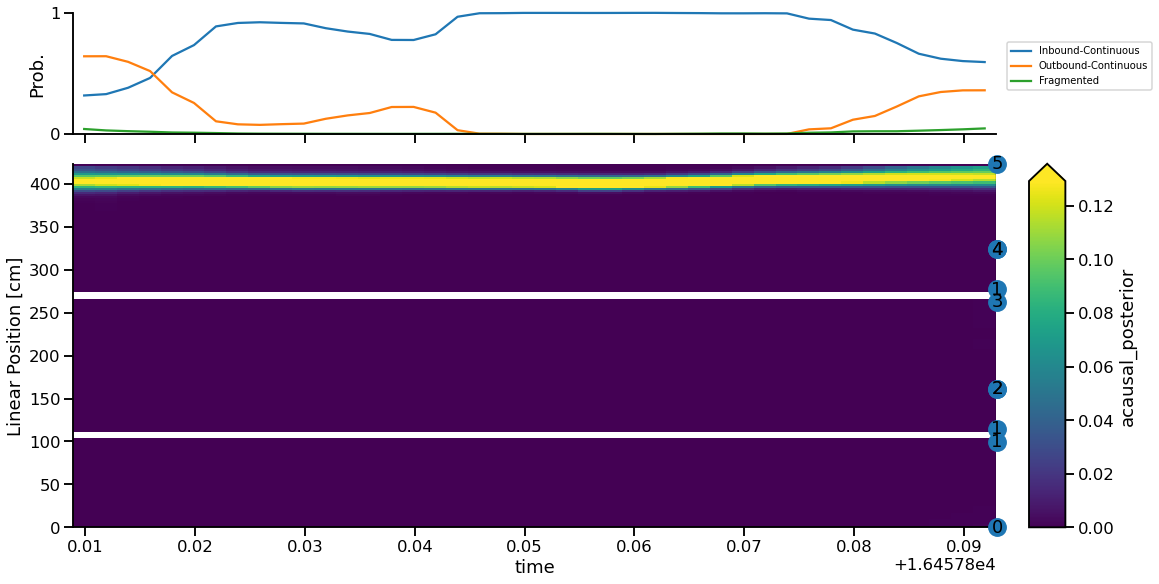

In [85]:
ripple_number = 20

plot_ripple_decode(data, classifier, ripple_number)

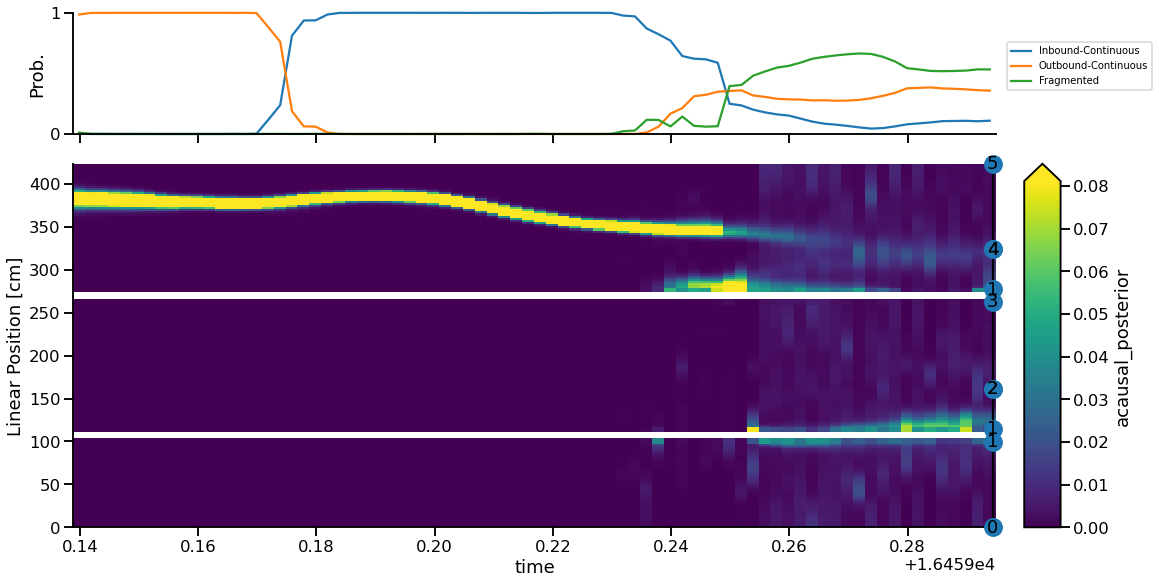

In [86]:
ripple_number = 21

plot_ripple_decode(data, classifier, ripple_number)

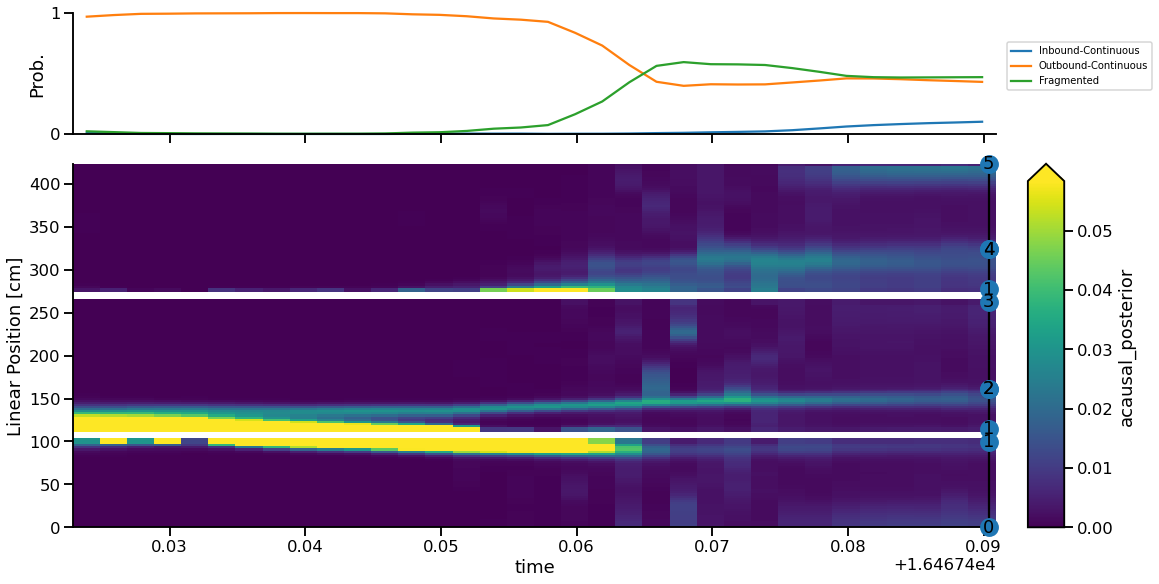

In [87]:
ripple_number = 22

plot_ripple_decode(data, classifier, ripple_number)

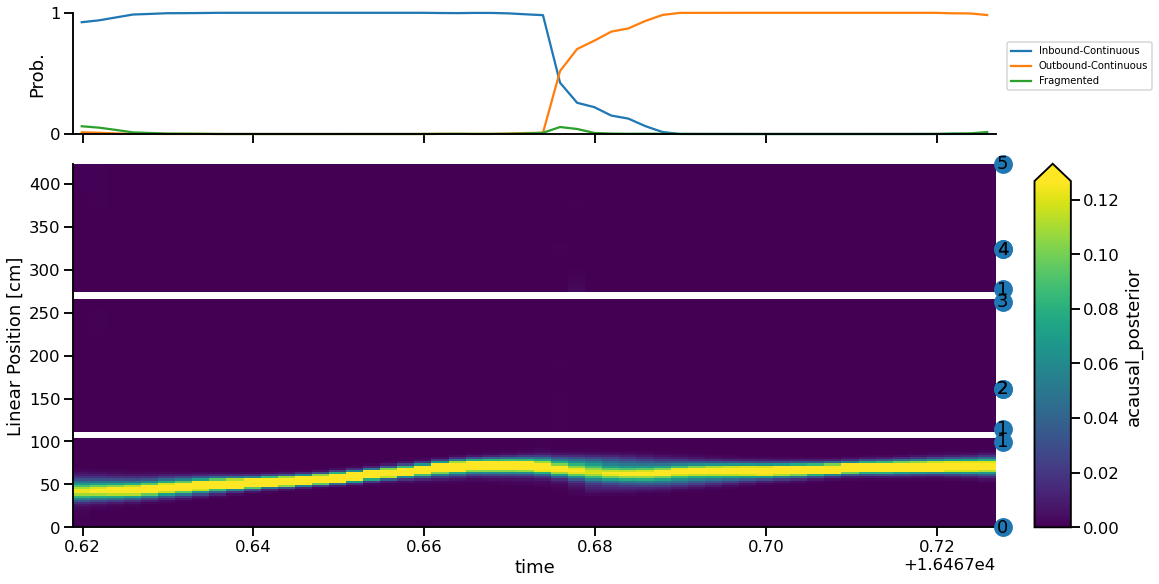

In [88]:
ripple_number = 23

plot_ripple_decode(data, classifier, ripple_number)

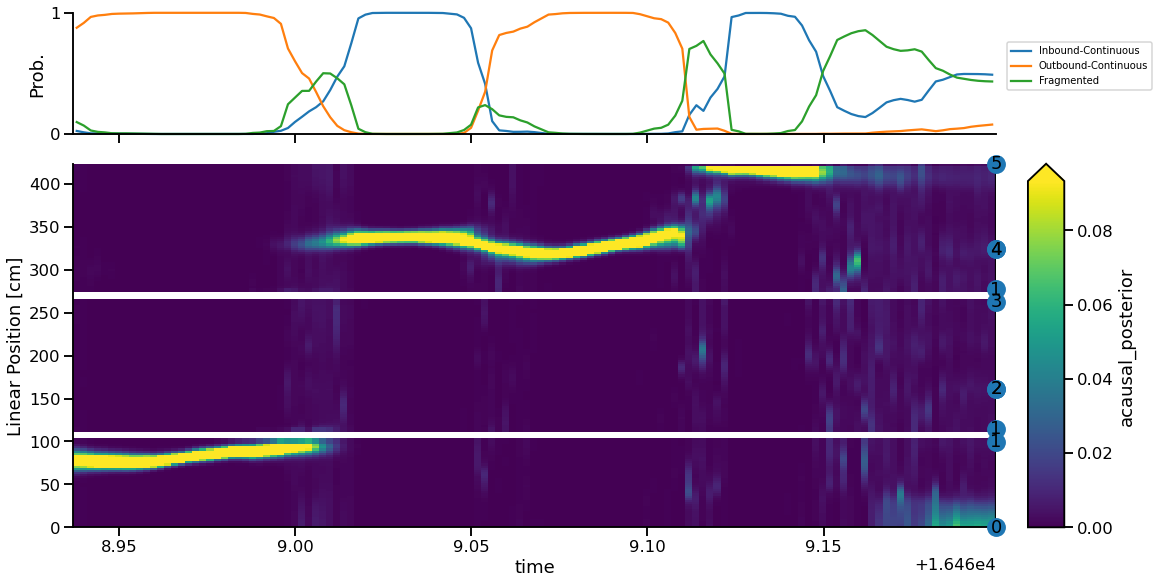

In [89]:
ripple_number = 24

plot_ripple_decode(data, classifier, ripple_number)

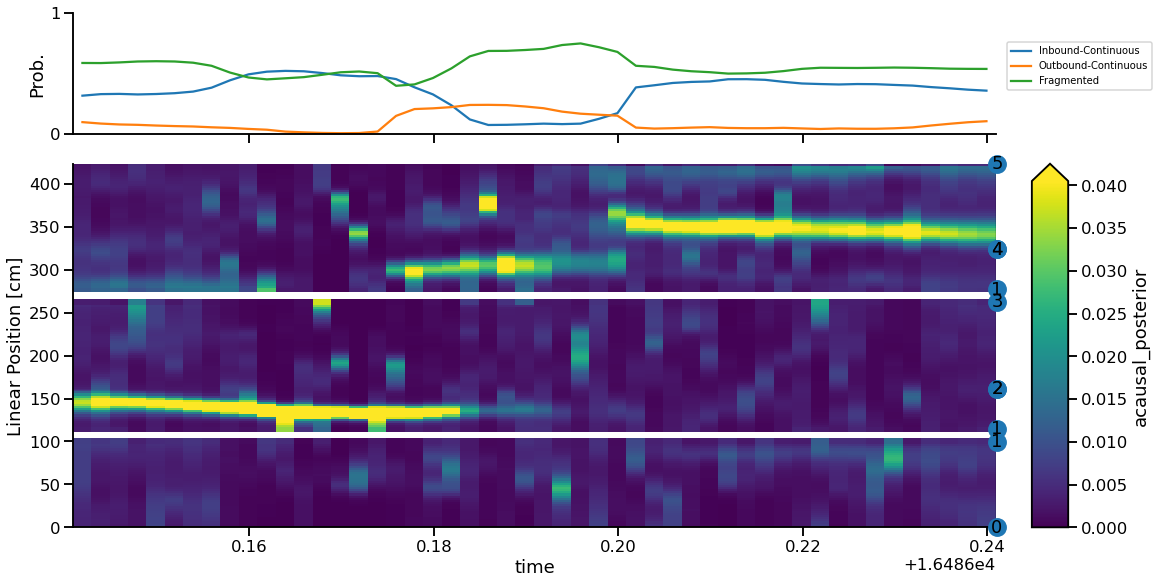

In [90]:
ripple_number = 25

plot_ripple_decode(data, classifier, ripple_number)